In this demo, we'll be demonstrating how capsa, the model-agnostic risk awareness framework that we've developed at Themis AI, can automatically detect bias in datasets of faces. Here, the dataset we've chosen here is the Celeb-A dataset, which containts over 200K celebrity images. We create a face classification task by choosing random samples from ImageNet as negatives.

First, we import the necessary dependencies, set some important hyperparameters, and load the data

In [1]:
import cv2
import os
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import time
import h5py
import sys
import glob
import functools
from train_dataloader import TrainingDatasetLoader
from tqdm import tqdm
import functools

In [2]:
latent_dim = 100
batch_size = 32

In [3]:
data_path = tf.keras.utils.get_file(
    "train_face.h5", "https://www.dropbox.com/s/hlz8atheyozp1yx/train_face.h5?dl=1"
)
dataloader = TrainingDatasetLoader(data_path, batch_size=batch_size)
sample_batch_imgs, _ = dataloader.return_sample_batch()


Opening /home/sadhanalolla/.keras/datasets/train_face.h5
Loading data into memory...


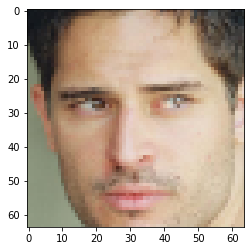

In [6]:
plt.imshow(sample_batch_imgs[30])

We create a standard CNN to classify the images as faces or negatives

In [7]:
"""Function to define a standard CNN model"""

def make_standard_classifier(n_outputs=1, n_filters=12):
  Conv2D = functools.partial(tf.keras.layers.Conv2D, padding='same', activation='relu')
  BatchNormalization = tf.keras.layers.BatchNormalization
  Flatten = tf.keras.layers.Flatten
  Dense = functools.partial(tf.keras.layers.Dense, activation='relu')

  model = tf.keras.Sequential([
    Conv2D(filters=1*n_filters, kernel_size=5,  strides=2),
    BatchNormalization(),
    
    Conv2D(filters=2*n_filters, kernel_size=5,  strides=2),
    BatchNormalization(),

    Conv2D(filters=4*n_filters, kernel_size=3,  strides=2),
    BatchNormalization(),

    Conv2D(filters=6*n_filters, kernel_size=3,  strides=2),
    BatchNormalization(),

    Flatten(),
    Dense(512),
    Dense(n_outputs, activation=None),
  ])
  model.build((None, 64, 64, 3))
  return model

standard_classifier = make_standard_classifier()

In [14]:
from capsa import wrap, VAEWrapper, HistogramCallback

Now, we wrap the standard classifier. In this example, we choose the VAE, or variational autoencoder, and analyze the biases in the dataset. The VAE can also be used to quantify epistemic uncertainty, but we choose to focus on bias here. With this one line, we've now created a risk-aware model!

In [10]:
wrapped_classifier = VAEWrapper(
    standard_classifier,
    latent_dim=latent_dim,
    epistemic=False,
)

In [ ]:
wrapped_classifier = wrap()

We choose hyperparameters, load our training data, and compile the model just as we would a normal Keras model.

In [15]:
# Training hyperparameters
num_epochs = 6  # keep small to run faster
learning_rate = 1e-5

wrapped_classifier.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate),
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[tf.keras.metrics.BinaryAccuracy()],
)

Lastly, we fit the model. We can use any of the capabilities of a normal Keras model with the wrapped model, and fit is no exception.

In [16]:
history = wrapped_classifier.fit(
    dataloader,
    epochs=num_epochs,
    batch_size=batch_size,
    callbacks=[HistogramCallback()]
)

2022-08-29 16:52:22.000543: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8100
2022-08-29 16:52:24.359214: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


TypeError: Exception encountered when calling layer "vae_wrapper" (type VAEWrapper).

call() got an unexpected keyword argument 'softmax'

Call arguments received by layer "vae_wrapper" (type VAEWrapper):
  • x=tf.Tensor(shape=(32, 64, 64, 3), dtype=float32)
  • training=False
  • return_risk=True
  • features=None
  • softmax=False

Now that our model is trained, we load the test dataset.

Opening /home/sadhanalolla/.keras/datasets/train_face.h5
Loading data into memory...


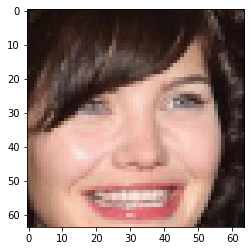

In [18]:
test_dataloader = TrainingDatasetLoader(data_path, batch_size=32, training=False)
selected_inds = test_dataloader.train_inds
sorted_inds = np.sort(selected_inds)
test_img = (test_dataloader.images[sorted_inds, :, :, ::-1] / 255.0).astype(np.float32)
test_label = test_dataloader.labels[sorted_inds, ...]
plt.imshow(test_img[0])

We call the wrapped classifier on the test dataset and sort the dataset in order of increasing bias.

In [23]:
test_outs = wrapped_classifier(test_img, softmax=True)
test_biases = np.squeeze(test_outs[1])

sorted_bias_inds = np.argsort(test_biases)
sorted_biases = np.array(test_biases[sorted_bias_inds])
sorted_images = np.array(test_img[sorted_bias_inds])

In [24]:
num_images = 20
num_samples = len(test_img) // num_images

Shown below are the 20 images with the lowest bias (i.e. the least represented in the dataset). We can see that varied facial position and obstructing items such as hats and sunglasses are underrepresented in this dataset

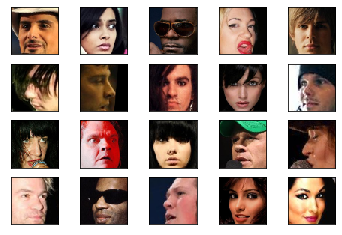

<Figure size 432x288 with 0 Axes>

In [25]:
fig = plt.figure()
fig.subplots_adjust(hspace=0.6)
for img in range(num_images):
    ax = fig.add_subplot(int(num_images/5), 5, img + 1)
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
    img_to_show = sorted_images[img]
    ax.imshow(img_to_show, interpolation="nearest")
plt.subplots_adjust(wspace=0.20,hspace=0.20)
plt.show()
plt.clf()

Here we see the top 20 samples that the dataset is biased towards. These are overwhemingly light-skinned females with light hair, and almost all the people in these images are directly facing the camera

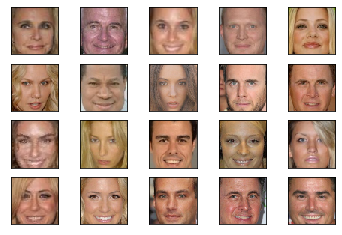

In [26]:
fig = plt.figure()
fig.subplots_adjust(hspace=0.6)
for img in range(-1 * num_images, 0):
    ax = fig.add_subplot(int(num_images/5), 5, -1 * img)
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
    img_to_show = sorted_images[img]
    ax.imshow(img_to_show, interpolation="nearest")
plt.subplots_adjust(wspace=0.20,hspace=0.20)
plt.show()


Now, we plot the average face by percentile. The top left image shows the average face of the bottom 5th percentile in terms of bias, and we can see that the average skin tone and hair color is darker than the faces in the higher percentiles. 

In [27]:
all_imgs = []
all_bias = []
for percentile in range(num_images):
    cur_imgs = sorted_images[percentile * num_samples : (percentile + 1) * num_samples]
    cur_bias = sorted_biases[percentile * num_samples : (percentile + 1) * num_samples]
    avged_imgs = tf.reduce_mean(cur_imgs, axis=0)
    all_imgs.append(avged_imgs)
    all_bias.append(tf.reduce_mean(cur_bias))

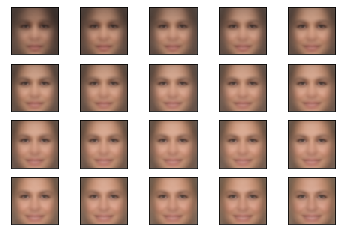

In [28]:
fig = plt.figure()
fig.subplots_adjust(hspace=0.6)
for img in range(num_images):
    ax = fig.add_subplot(int(num_images/5), 5, img + 1)
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
    img_to_show = all_imgs[img]
    ax.imshow(img_to_show, interpolation="nearest")
plt.subplots_adjust(wspace=0.20,hspace=0.20)
plt.savefig("percentile.PNG")

By including a single line in our normal training workflow, we've found significant bias in our dataset!